<a href="https://colab.research.google.com/github/Thevakumar-Luheerathan/EN4353-Radar-and-Navigation/blob/main/170351P_Radar_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EN4353 - RADAR AND NAVIGATION - ASSIGNMENT - 01

T.LUHEERATHAN - 170351P

# Load the data files 

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Load the raw files from github
url_1='https://raw.githubusercontent.com/Thevakumar-Luheerathan/EN4353-Radar-and-Navigation/main/Assignment%201/raw_data1.csv'
url_2='https://raw.githubusercontent.com/Thevakumar-Luheerathan/EN4353-Radar-and-Navigation/main/Assignment%201/raw_data2.csv'
url_3='https://raw.githubusercontent.com/Thevakumar-Luheerathan/EN4353-Radar-and-Navigation/main/Assignment%201/raw_data3.csv'

raw_data1= np.genfromtxt(url_1, delimiter=',', skip_header = 1)
raw_data2= np.genfromtxt(url_2, delimiter=',', skip_header = 1)
raw_data3= np.genfromtxt(url_3, delimiter=',', skip_header = 1)

#Provide the file which needs to be loaded
raw_data=raw_data3



# Radar parameters

* No.of Range slots $N = 30$ 
* Radar rotation speed $Rspeed=12RPM$

* Pulse Repetition Frequency $fr = 1800 Hz$

* Sampling Frequency $Fs = 1080kHz$

* Available samples per data file  $Nsample = 18000$

* Noise parameter $sigman = 1$

* Speed of Light $C=3\times10^{8}ms^{-1}$

* Horizontal Beam Width $Htheta=2 deg$
* Window size $Nwindow$ = $21$
* Guard band size $Nguard=4$
* theta_init=0





In [ ]:
N=30
Rspeed=12
fr=1800
fs=1080
Nsample=18000
sigman=1
C=3e8
Htheta=2
Nwindow=21
Nguard=4
theta_init=0

# Data matrix detemination and Downsampling point selection

> Available sample per echo ($Nsample_-echo$) = $fs$/$fr$ = $1080 000$/$1800$ = $600$

> Available echoes in the raw file($Necho_-raw$) = $Nsample$/$Nsample_-echo$ = $18000$/$600$ = $30$

> No of echoes per target per sweep = ( $Htheta$ x $fr$ )/($6$$N$)= 50

As available echoes in the raw file is less than No of echoes per target per sweep, we can safely assume that all the available echoes are from same target. So, The data matrix dimension is $30$ x $30$.

As the No of bins per echo is 30. The samples need to be downsapmled further at factor ($ds_-factor$) of 20. ( $Nsample_-echo$/$N$ = $600$/$30$ = $20$)

Downsampled data can be used reshaped as $30$ x $30$ data matrix.

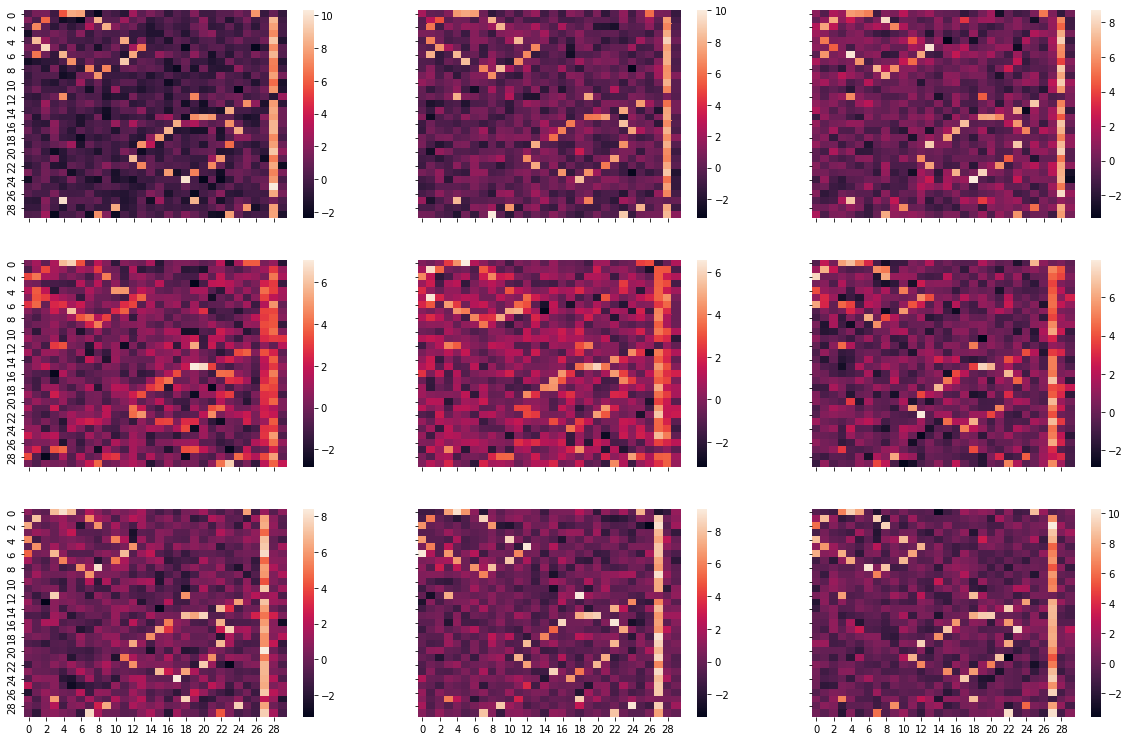

In [ ]:
Nsample_echo=fs*1000/fr
Necho_raw=int(Nsample/Nsample_echo)
ds_factor=int(Nsample_echo/N)


#Downsampling (sample is taken from 0,2,8,10,12,14,16,18 th point and taken for every 20 point interval to get more appropriate sample
ds_raw_data_s=[]
ds_raw_data_s.extend([(raw_data[0::ds_factor]).copy(),(raw_data[2::ds_factor]).copy(),(raw_data[4::ds_factor]).copy(),(raw_data[8::ds_factor]).copy(),
                      (raw_data[10::ds_factor]).copy(),(raw_data[12::ds_factor]).copy(),(raw_data[14::ds_factor]).copy(),
                      (raw_data[16::ds_factor]).copy(),(raw_data[18::ds_factor]).copy()])
fig, axn = plt.subplots(3, 3, sharex=True, sharey=True,figsize=(20,13))
for i, ax in enumerate(axn.flat):
    sns.heatmap(ds_raw_data_s[i].reshape((N,Necho_raw)), ax=ax)



Sample can be taken from 0 sample onwards for every 20 sample intervals. It will give more clear results.

# Selecting Appropriate noise threshold k
Average threshold needs to be calculated for each bin. For this purpose a 21 sample window is chosen. Except 1st sample (sample with 0 index), every other sample is located in the middle of the window. 1st sample is chosen with half of the window size (only has future video, No past video). Among 20 future and past video samples, 8 samples are eleminated for guard band. So, past and future video set has 6 samples in each. 

Multiple k value are chosen and plotted to find out more appropriate k.

Noise average $(V_n)_{avg}\:$ for a bin can be obtained as follows:

>$(V_n)_{avg} = \frac{\sum_{i=5}^{10} (past video) + \sum_{i=5}^{10} (future video)}{12}$

Thresold value for a bin is:

>$V_{TH}=(V_n)_{avg}+k\cdot \sigma_n $

After the noise filtering, resulted vector is reshaped to a 30 x 30 matrix.!

A simple threshold mechanism is applied

> $If\:\: V_{k}>V_{TH} \:\: then \:V_{k} =1 \:otherwise \:0$


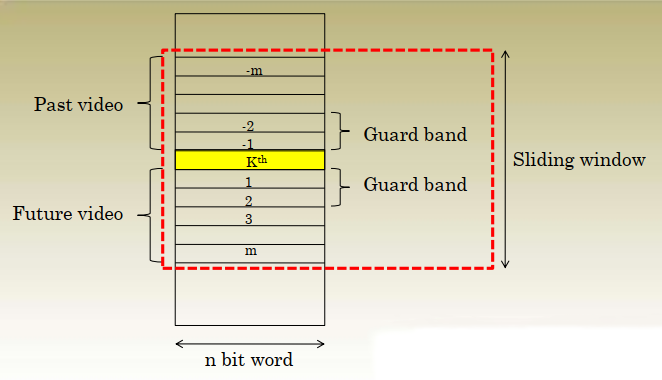

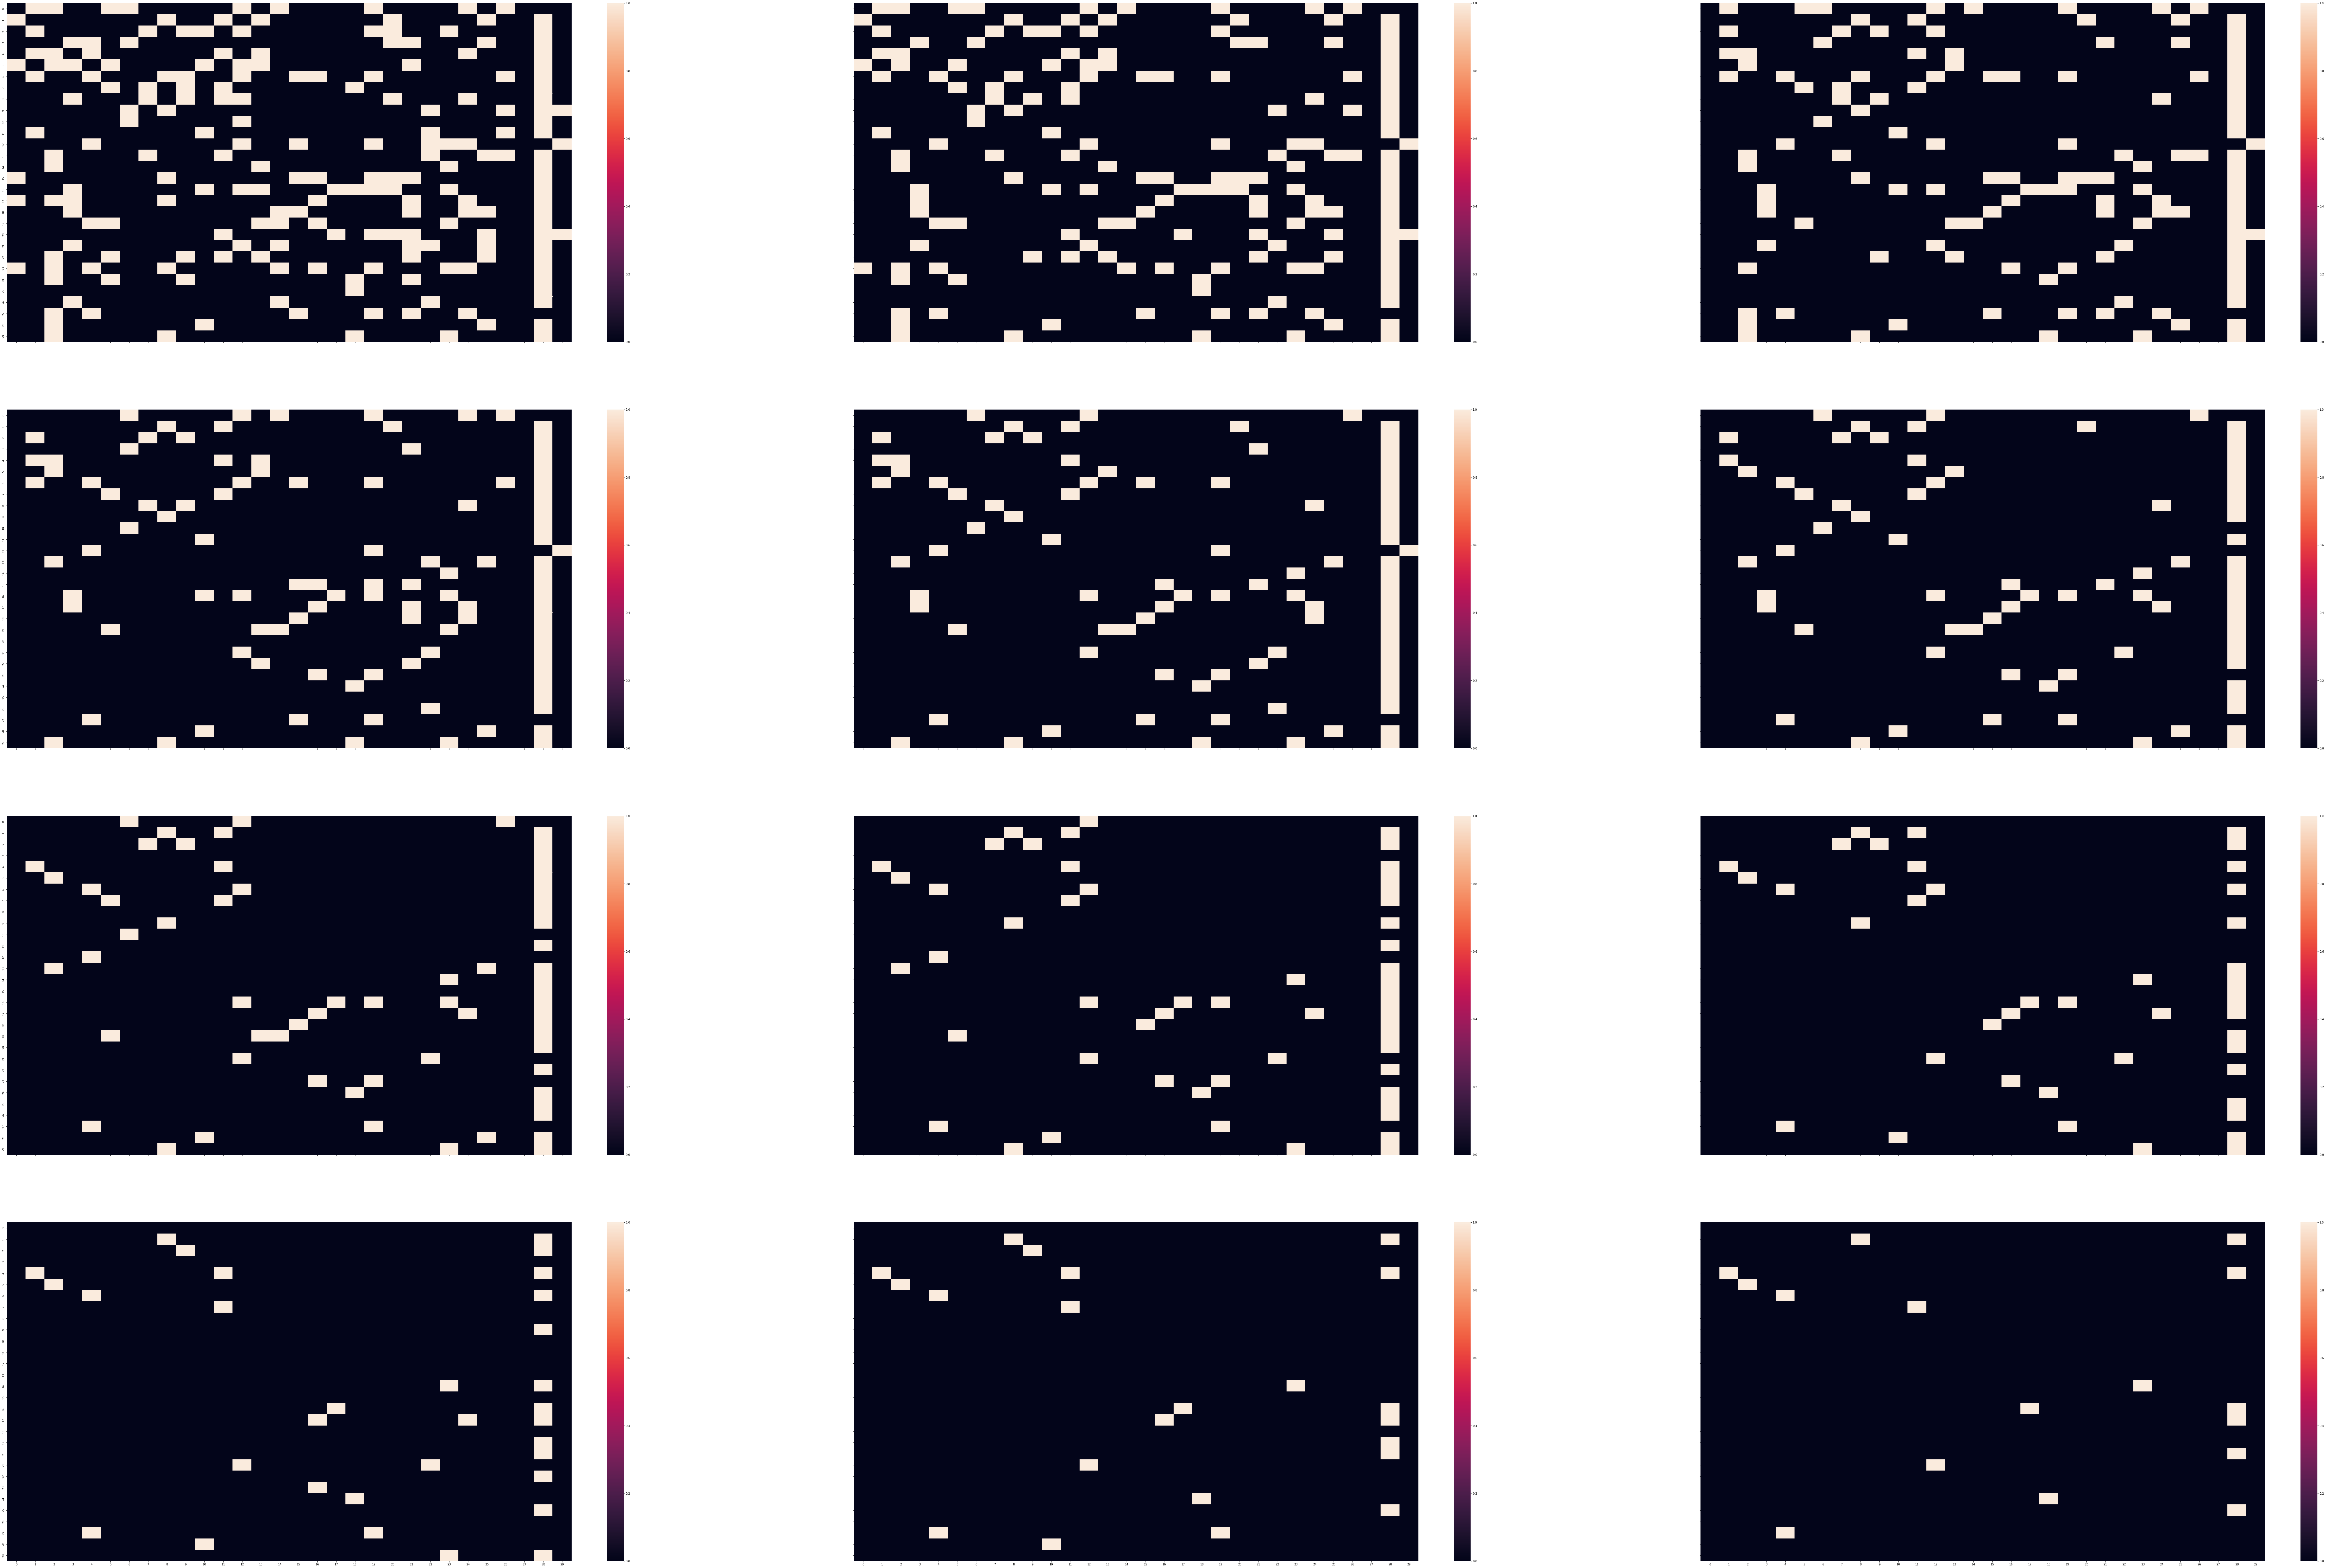

In [ ]:
#Assigning the samples which are taken from 0th sample onwards.
ds_raw_data=ds_raw_data_s[0]
#Intialising a random vector with zeros to save the noise average for all the samples.
vn_avg_vector= np.zeros((ds_raw_data.size,))

#Noise average calculation for all the samples
for i in range(0,raw_data.size,ds_factor):
  if i==0:
    window=raw_data[0:i+1+(Nwindow-1)//2].copy()
    vn_avg=(np.sum(window[((Nwindow-1)//2)+Nguard+1:]))/((Nwindow-1)//2-Nguard)
  else:
    window=raw_data[i-(Nwindow-1)//2:i+1+(Nwindow-1)//2].copy()
    vn_avg=(np.sum(window[0:((Nwindow-1)//2)-Nguard])+np.sum(window[((Nwindow-1)//2)+Nguard+1:]))/(Nwindow-1-2*Nguard)
  vn_avg_vector[(i//((Nwindow-1)//2))//2]=vn_avg

#Data point calcultion for various k (Noise threshold parameter)  to choose proper k
data_mat_k=[]
for k in range(100,510,25):
  vn_th_vector=vn_avg_vector+(k/100)*sigman
  #Data matrix
  data_vect=ds_raw_data>vn_th_vector
  data_mat=data_vect.reshape((Necho_raw,N))
  data_mat_k.append(data_mat)

fig, axn = plt.subplots(4, 3, sharex=True, sharey=True,figsize=(150,100))
for i, ax in enumerate(axn.flat):
    sns.heatmap(data_mat_k[i], ax=ax)


$k=1.5$ is chosen as the noise parameter.
# Post detection integration
If target is available. No of 1 is greater than the No of 0. And such column is replaced with 0.5. A inverse filter is built to remove target in a later stage during cloud detection.

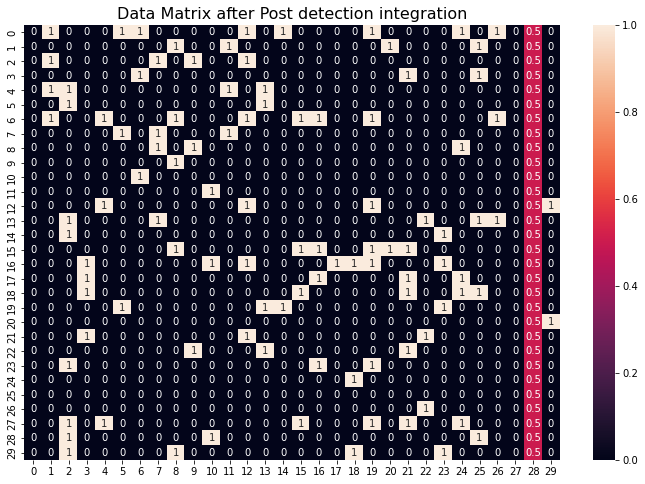

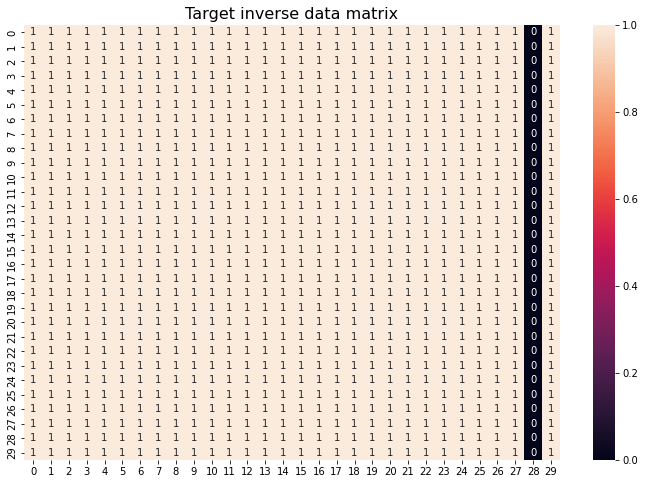

In [ ]:
# Selecting the data matrix correspond to approariate k.
data_mat_target=data_mat_k[2].astype(float)

#A inverse filter to remove target in a later stage during cloud detection
target_bin=[]
data_mat_target_inv=(data_mat_k[2].astype(float)).copy()
for i in range(N):
  if np.sum(data_mat_target[:,i])>Necho_raw/2:
      data_mat_target[:,i]=0.5
      data_mat_target_inv[:,i]=0
      target_bin.append(i)
  else:
      data_mat_target_inv[:,i]=1

  
plt.figure(figsize = (12,8))
plt.title("Data Matrix after Post detection integration",fontsize = 16)
ax = sns.heatmap(data_mat_target,annot=True)
plt.figure(figsize = (12,8))
plt.title("Target inverse data matrix",fontsize = 16)
ax = sns.heatmap(data_mat_target_inv,annot=True)

# Cloud detection
Make the things easier, detected targets are removed. Values < 4 are also filtered out in the original data matrix . Then resulted data matrix is added to the highly noise filtered matrix (k=3) to increase the confident of detection (Strong cloud elements are visible more) and to avoid the cloud suppression due to high noise (Part of the cloud which is suppressed by noise visible).

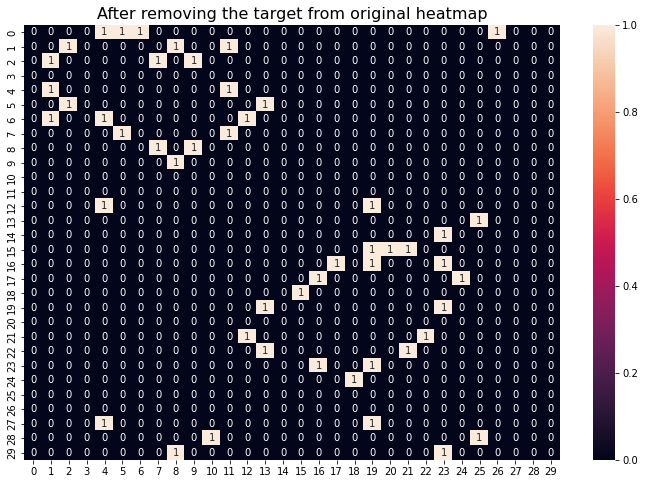

In [ ]:
#Removing the target from the data matrix
data_mat_cloud= np.multiply((np.multiply(ds_raw_data.reshape((N,Necho_raw)),data_mat_target_inv))>4,(np.multiply(ds_raw_data.reshape((N,Necho_raw)),data_mat_target_inv)))
plt.figure(figsize = (12,8))
plt.title("After removing the target,combined data matrix",fontsize = 16)
data_mat_cloud=(data_mat_cloud>0)
# Highly Noise filterd data matrix 
noise_filtered_data_mat=(np.multiply(data_mat_target_inv,data_mat_k[8])>0)
data_mat_cloud=data_mat_cloud |  noise_filtered_data_mat
ax = sns.heatmap(data_mat_cloud,annot=True)

Pad of 2 is used with padder 0 so that the (5x5) filter can be applied to the edge too.
filter chracteristics
  - Mid of the kernal is 0 and other elements are 1.
  - Convolution operation is carried out only if the the kernal 0 (mid element) aligned with a 1 while moving the kernal through the data matrix.
  - If kernal convolution is 0 then coresponding mid elemnent is replaced with 0.
  - If the kernal convolution is not 0 then, missing elements with 1 box distance are placed with 1.5
  - unnecessary 1.5s are removed
  - Remaining 1.5s converted to 1

After applying kernal, missing boxes(missing by 1 box) at the cloud edge is filled.

 Kernal used:

                      [[1,1,1,1,1],
                       [1,1,1,1,1],
                       [1,1,0,1,1],
                       [1,1,1,1,1],
                       [1,1,1,1,1]]



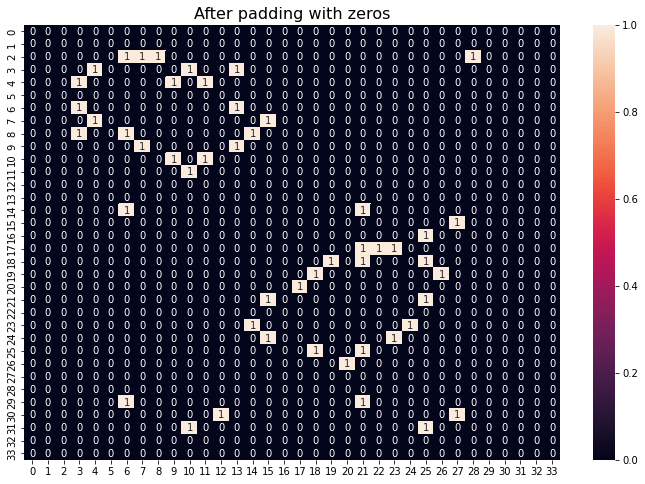

In [ ]:
#Padding is applied initially
data_mat_cloud_padded= np.pad(data_mat_cloud, 2,mode='constant')
plt.figure(figsize = (12,8))
plt.title("After padding with zeros",fontsize = 16)
ax = sns.heatmap(data_mat_cloud_padded,annot=True)

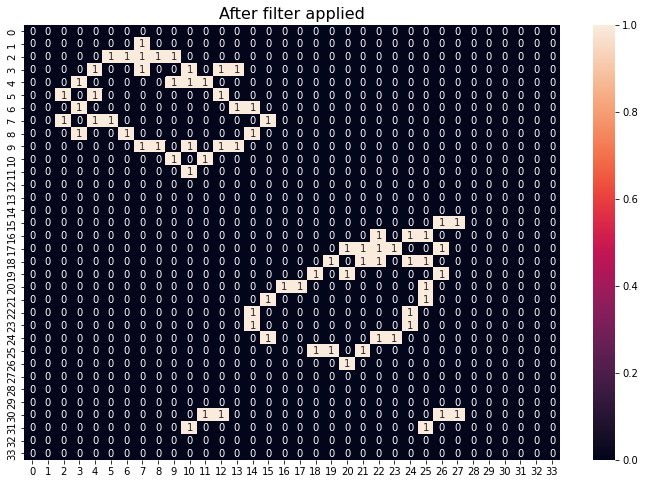

In [ ]:

#Find the index of near by elements
def near_by(i,j):
  return [(i-1,j-1),(i-1,j),(i-1,j+1),(i,j+1),(i+1,j+1),(i+1,j),(i+1,j-1),(i,j-1)]

#Applying kernal
kernal =np.array([[1,1,1,1,1],[1,1,1,1,1],[1,1,0,1,1],[1,1,1,1,1],[1,1,1,1,1]])
data_mat_cloud_padded=(data_mat_cloud_padded).astype(float)
for i in range(2,data_mat_cloud_padded.shape[1]-2):
  for j in range(2,data_mat_cloud_padded.shape[0]-2):
    if data_mat_cloud_padded[j,i]==1:
      matrix=(data_mat_cloud_padded[j-2:j+3,i-2:i+3]).copy()
      conv_val=np.sum(np.multiply(matrix,kernal))
      if conv_val==0:
        data_mat_cloud_padded[j,i]=0
      else:
        near_by_1box=near_by(i,j)
        for temp_i,temp_j in near_by_1box:
          if data_mat_cloud_padded[temp_j,temp_i]==0:
            near_by_2box=near_by(temp_i,temp_j)
            count=0
            for temp_i2,temp_j2 in near_by_2box:
              if (data_mat_cloud_padded[temp_j2,temp_i2]==1 and ((temp_i2,temp_j2) not in near_by_1box)):
                count+=1
            if count>=2:
              data_mat_cloud_padded[temp_j,temp_i]=1.5

#Remove the 1.5 points which are not necessary to fill gaps and added multiple times
for x in range(1,data_mat_cloud_padded.shape[1]-1):
  for y in range(1,data_mat_cloud_padded.shape[0]-1):
    if data_mat_cloud_padded[x,y]==1.5:
      near_by_rm=near_by(x,y)
      for i,j in near_by_rm:
        if data_mat_cloud_padded[i,j]==1.5:
          data_mat_cloud_padded[i,j]=0
      



data_mat_cloud_padded=data_mat_cloud_padded>=1
plt.figure(figsize = (12,8))
plt.title("After kernal is applied",fontsize = 16)
ax = sns.heatmap(data_mat_cloud_padded,annot=True)



A Bresenham's line generation algorithm is used along with flood() method to fill the gaps within the cloud.

In [ ]:
#Bresenham algorithm to find the intermediate points in a line
def bresenham(x0,y0,x1,y1):
    diff_x = x1 - x0
    diff_y = y1 - y0
    

    steep_ = abs(diff_y) > abs(diff_x)

  
    if steep_:
        x0, y0 = y0, x0
        x1, y1 = y1, x1

    swap_ = False
    if x0 > x1:
        x0, x1 = x1, x0
        y0, y1 = y1, y0
        swap_ = True

  
    diff_x = x1 - x0
    diff_y = y1 - y0

    error_ = int(diff_x / 2.0)
    ystep = 1 if y0 < y1 else -1


    y = y0
    points = []
    x=x0
    while (x<x1+1):
        if steep_:
           coord  = (y, x) 
        else:
            coord =(x, y)
        points.append(coord)
        error_ -= abs(diff_y)
        if error_ < 0:
            y += ystep
            error_ += diff_x
        x+=1


    if swap_:
        points.reverse()
    return points

#Algorithm to fill the spaces
def flood(mat):
    count=0
    x_s,y_s=mat.shape
    i=0
    while (i<y_s):

        j=0
        while(j<x_s):

            k=0
            while(k<y_s):
            
                l=0
                while(l<x_s):
                    dist1=2
                    dist2=8**0.5
                      
                    if dist1<=(((l-j)**2 +(k-i)**2)**0.5)<=dist2 and mat[i,j]==1 and mat[k,l]==1:
                        count+=1
                        points=bresenham(i, j, k, l)
                        for m in points:                            
                            xm,ym=m
                            mat[xm,ym]=1  
                    l+=1
                k+=1
            j+=1
        i+=1                                         
    return mat

data_mat_cloud_padded=flood(data_mat_cloud_padded.copy())
data_mat_cloud_unpadded=data_mat_cloud_padded[2:data_mat_cloud_padded.shape[0]-2,2:data_mat_cloud_padded.shape[1]-2]

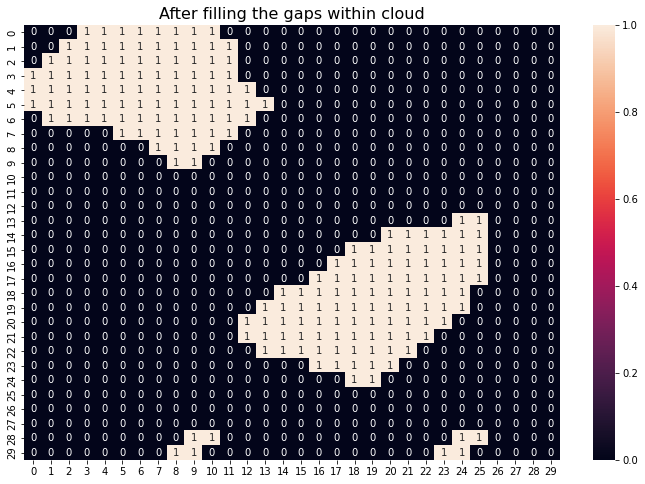

In [ ]:
plt.figure(figsize = (12,8))
plt.title("After filling the gaps within cloud",fontsize = 16)
ax = sns.heatmap(data_mat_cloud_unpadded,annot=True)

Noise around a single pixel is removed by applying Morphological transformations.

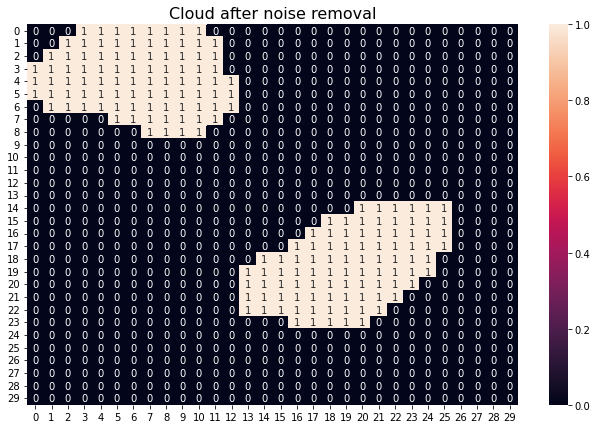

In [ ]:
import cv2
kernel = np.ones((3,3),np.uint8)

filtered_cloud = cv2.morphologyEx((data_mat_cloud_unpadded.copy()).astype(np.uint8), cv2.MORPH_OPEN, kernel)

plt.figure(figsize = (11,7))
plt.title("Cloud after noise removal",fontsize = 16)
ax = sns.heatmap(filtered_cloud,annot=True)

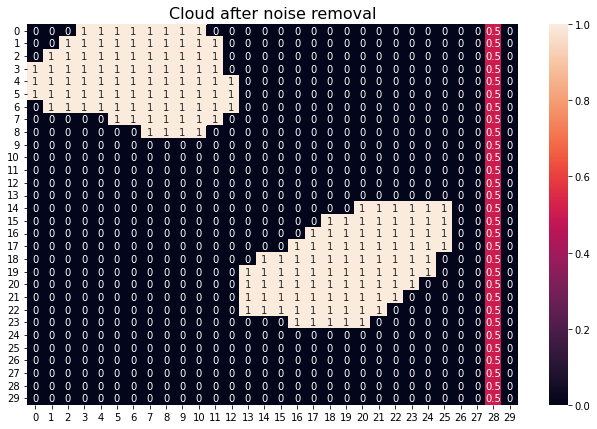

In [ ]:
data_mat_target=(data_mat_target_inv<=0)*0.5
data_mat_cloud_n_taget=filtered_cloud+data_mat_target
plt.figure(figsize = (11,7))
plt.title("Cloud after noise removal",fontsize = 16)
ax = sns.heatmap(data_mat_cloud_n_taget,annot=True)

# Calculating the range of the objects
For range and azimuth angle calculations:

$\Delta R = \frac{c \times T_{s}}{2} = 2778m$

$\omega_{radar} = \frac{revol\:speed\times2\pi}{60}$

following equations were used to calculate the range and azimuth angle of the target.

$
\\
\theta_k = \theta_{init} + \omega_{radar}\times \frac{1}{2\cdot F_s} \times bin\_number
\\
\\
R_k = \Delta R \times bin\_number 
\\
\\
p_k = (R_k, \theta_k)$

In [ ]:
if len(target_bin) != 0:
    k = (Rspeed*360/60) * (1/(2*N*fr))
#     print(k)
    azymuth = theta_init+ np.dot(np.add(target_bin,1),k)
#     print(azymuth)
    range_m = np.dot(C/(2*N*fr),np.add(target_bin,1))
#     print(range_m)
    for i,(r, theta) in enumerate(zip(range_m, azymuth)):
        print(f'Target {i} is at ({r*1e-3:.3f}km, {theta:.3f}deg)')
else:
    print('No target detected')


Target 0 is at (80.556km, 0.019deg)
